In [1]:
%cd /home/thucth/thucth/project/insightface/recognition/arcface_torch_datagen
# env torch19

/home/thucth/thucth/project/insightface/recognition/arcface_torch_datagen


## Convert Arcface into AdaFace heads

In [340]:
# Dummy input/labels
embs = torch.randn(2,512)
norm = torch.norm(embs,2,dim=-1,keepdim=True)
embs = torch.div(embs, norm)
labels = torch.tensor([6,9])
print("embs.shape: ",embs.shape) 
print("norm.shape: ",norm.shape) 
print("labels.shape: ",labels.shape) 

embs.shape:  torch.Size([2, 512])
norm.shape:  torch.Size([2, 1])
labels.shape:  torch.Size([2])


In [306]:
import torch
import math
from torch.nn import CrossEntropyLoss


def l2_norm(input,axis=-1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output
class AdaFaceWAct(torch.nn.Module):
    ''' 
    1. Multiply embeddings with W (W phase)
    2. Compute Adaface Activate (like normalized softmax) (Act phase)
    '''
    def __init__(self,
                 embedding_size=512,
                 classnum=70722,
                 m=0.4,
                 h=0.333,
                 s=64.,
                 t_alpha=1.0,
                 ):
        super(AdaFaceWAct, self).__init__()
        self.classnum = classnum
        self.kernel = torch.nn.Parameter(torch.Tensor(embedding_size,classnum))
        # # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        # self.kernel = torch.nn.Parameter(torch.ones(embedding_size,classnum)) for debug without randomness

        self.m = m 
        self.eps = 1e-3
        self.h = h
        self.s = s

        # ema prep
        self.t_alpha = t_alpha
        self.register_buffer('t', torch.zeros(1))
        self.register_buffer('batch_mean', torch.ones(1)*(20))
        self.register_buffer('batch_std', torch.ones(1)*100)

        print('\n\AdaFaceWAct with the following property')
        print('self.m', self.m)
        print('self.h', self.h)
        print('self.s', self.s)
        print('self.t_alpha', self.t_alpha)

    def forward(self, embbedings, norms, label):
        kernel_norm = l2_norm(self.kernel,axis=0)
        print(kernel_norm)
        cosine = torch.mm(embbedings,kernel_norm)
        cosine = cosine.clamp(-1+self.eps, 1-self.eps) # for stability
        
        print(cosine)
        
        safe_norms = torch.clip(norms, min=0.001, max=100) # for stability
        safe_norms = safe_norms.clone().detach()

        # update batchmean batchstd
        with torch.no_grad():
            mean = safe_norms.mean().detach()
            std = safe_norms.std().detach()
            self.batch_mean = mean * self.t_alpha + (1 - self.t_alpha) * self.batch_mean
            self.batch_std =  std * self.t_alpha + (1 - self.t_alpha) * self.batch_std

        margin_scaler = (safe_norms - self.batch_mean) / (self.batch_std+self.eps) # 66% between -1, 1
        margin_scaler = margin_scaler * self.h # 68% between -0.333 ,0.333 when h:0.333
        margin_scaler = torch.clip(margin_scaler, -1, 1)
        # ex: m=0.5, h:0.333
        # range
        #       (66% range)
        #   -1 -0.333  0.333   1  (margin_scaler)
        # -0.5 -0.166  0.166 0.5  (m * margin_scaler)

        # g_angular
        m_arc = torch.zeros(label.size()[0], cosine.size()[1], device=cosine.device)
        m_arc.scatter_(1, label.reshape(-1, 1), 1.0)
        g_angular = self.m * margin_scaler * -1
        m_arc = m_arc * g_angular
        theta = cosine.acos()
        theta_m = torch.clip(theta + m_arc, min=self.eps, max=math.pi-self.eps)
        cosine = theta_m.cos()

        # g_additive
        m_cos = torch.zeros(label.size()[0], cosine.size()[1], device=cosine.device)
        m_cos.scatter_(1, label.reshape(-1, 1), 1.0)
        g_add = self.m + (self.m * margin_scaler)
        m_cos = m_cos * g_add
        cosine = cosine - m_cos
        # scale
        scaled_cosine_m = cosine * self.s
        return scaled_cosine_m

cross_entropy_loss = CrossEntropyLoss()

adaface_w_act = AdaFaceWAct(embedding_size=512,
                 classnum=10,
                 m=0.4,
                 h=0.333,
                 s=64.,
                 t_alpha=1.0)

logits = adaface_w_act(embs,norm,labels)

loss_train = cross_entropy_loss(logits, labels)
print(loss_train)


\AdaFaceWAct with the following property
self.m 0.4
self.h 0.333
self.s 64.0
self.t_alpha 1.0
tensor([[0.0442, 0.0442, 0.0442,  ..., 0.0442, 0.0442, 0.0442],
        [0.0442, 0.0442, 0.0442,  ..., 0.0442, 0.0442, 0.0442],
        [0.0442, 0.0442, 0.0442,  ..., 0.0442, 0.0442, 0.0442],
        ...,
        [0.0442, 0.0442, 0.0442,  ..., 0.0442, 0.0442, 0.0442],
        [0.0442, 0.0442, 0.0442,  ..., 0.0442, 0.0442, 0.0442],
        [0.0442, 0.0442, 0.0442,  ..., 0.0442, 0.0442, 0.0442]],
       grad_fn=<DivBackward0>)
tensor([[ 0.0216,  0.0216,  0.0216,  0.0216,  0.0216,  0.0216,  0.0216,  0.0216,
          0.0216,  0.0216],
        [-0.0279, -0.0279, -0.0279, -0.0279, -0.0279, -0.0279, -0.0279, -0.0279,
         -0.0279, -0.0279]], grad_fn=<ClampBackward1>)
tensor(27.7968, grad_fn=<NllLossBackward>)


## Seperate W and Act

In [ ]:
from typing import Callable

def l2_norm(input,axis=-1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output
    
class AdaFC(torch.nn.Module):
    ''' 
    1. Multiply embeddings with W (FC phase)
    2. Compute Adaface Activate (like normalized softmax) (Act phase)
    '''
    def __init__(self,
                 margin_loss: Callable,
                 embedding_size=512,
                 classnum=70722,
                 ):
        super(AdaFC, self).__init__()
        self.classnum = classnum
        self.kernel = torch.nn.Parameter(torch.Tensor(embedding_size,classnum))
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        # self.kernel = torch.nn.Parameter(torch.ones(embedding_size,classnum)) for debug without randomness

        self.dist_cross_entropy = CrossEntropyLoss()

        # margin_loss
        if isinstance(margin_loss, Callable):
            self.margin_softmax = margin_loss
        else:
            raise

        # initial kernel
        self.eps = 1e-3

    def forward(self, embbedings, norms, labels):
        kernel_norm = l2_norm(self.kernel,axis=0)
        print(kernel_norm)
        logits = torch.mm(embbedings,kernel_norm)
        logits = logits.clamp(-1+self.eps, 1-self.eps) # for stability
        print(logits)
        logits = self.margin_softmax(logits,norms, labels)
        loss = self.dist_cross_entropy(logits, labels)
        return loss

class AdaAct(torch.nn.Module):
    ''' 
    This version is modified as ArcFace method
    1. Multiply embeddings with W (FC phase)
    2. Compute Adaface Activate (like normalized softmax) (Act phase)
    '''
    def __init__(self,
                 m=0.4,
                 h=0.333,
                 s=64.,
                 t_alpha=1.0,
                 ):
        super(AdaAct, self).__init__()
        self.m = m 
        self.eps = 1e-3
        self.h = h
        self.s = s
        
        # ema prep
        self.t_alpha = t_alpha
        self.register_buffer('batch_mean_z', torch.ones(1)*(20))
        self.register_buffer('batch_std_z', torch.ones(1)*100)

        print('\n\AdaFaceWAct with the following property')
        print('self.m', self.m)
        print('self.h', self.h)
        print('self.s', self.s)
        print('self.t_alpha', self.t_alpha)

    def forward(self, logits:torch.Tensor, norms:torch.Tensor, labels:torch.Tensor):

        logits = logits.clamp(-1+self.eps, 1-self.eps) # for stability
        
        safe_norms = torch.clip(norms, min=0.001, max=100) # for stability
        safe_norms = safe_norms.clone().detach()

        # update batchmean batchstd
        with torch.no_grad():
            mean_z = safe_norms.mean().detach()
            std_z = safe_norms.std().detach()
            self.batch_mean_z = mean_z * self.t_alpha + (1 - self.t_alpha) * self.batch_mean_z
            self.batch_std_z =  std_z * self.t_alpha + (1 - self.t_alpha) * self.batch_std_z


        z = (safe_norms - self.batch_mean_z) / (self.batch_std_z+self.eps)
        z = z * self.h 
        z = torch.clip(z, -1, 1)

        # g_angular shape(2,1)
        g_angular = - self.m * z 
        g_angular = g_angular.reshape(-1)
        
        index = torch.where(labels != -1)[0]
        target_logits = logits[index, labels[index].view(-1)]
        print(target_logits)
        theta = target_logits.acos()
        theta_m = torch.clip(theta + g_angular, min=self.eps, max=math.pi-self.eps)######
        target_logits_angular = theta_m.cos()

        # g_additive sahpe(2,1)
        g_add = self.m + (self.m * z)
        g_add = g_add.reshape(-1)
        target_logits_add = target_logits_angular - g_add
        # this is not easy_marin in arcface
        gap_ = 1 - self.m*z - self.m - (self.m*z).cos()
        gap_ = gap_.reshape(-1)

        final_target_logits = torch.where(theta + g_angular > 0, target_logits_add, target_logits+gap_)

        logits[index, labels[index].view(-1)] = final_target_logits
        logits = logits * self.s
        return logits

class AdaActOrigin(torch.nn.Module):
    ''' 
    This version is modified as Ogirinal ArcFace 
    1. Multiply embeddings with W (FC phase)
    2. Compute Adaface Activate (like normalized softmax) (Act phase)
    '''
    def __init__(self,
                 m=0.4,
                 h=0.333,
                 s=64.,
                 t_alpha=1.0,
                 ):
        super(AdaActOrigin, self).__init__()
        self.m = m 
        self.eps = 1e-3
        self.h = h
        self.s = s
        
        # ema prep
        self.t_alpha = t_alpha
        self.register_buffer('batch_mean_z', torch.ones(1)*(20))
        self.register_buffer('batch_std_z', torch.ones(1)*100)

        print('\n\AdaFaceWAct with the following property')
        print('self.m', self.m)
        print('self.h', self.h)
        print('self.s', self.s)
        print('self.t_alpha', self.t_alpha)

    def forward(self, logits:torch.Tensor, norms:torch.Tensor, labels:torch.Tensor):
        logits = logits.clamp(-1+self.eps, 1-self.eps) # for stability
        
        safe_norms = torch.clip(norms, min=0.001, max=100) # for stability
        safe_norms = safe_norms.clone().detach()

        # update batchmean batchstd
        with torch.no_grad():
            mean_z = safe_norms.mean().detach()
            std_z = safe_norms.std().detach()
            self.batch_mean_z = mean_z * self.t_alpha + (1 - self.t_alpha) * self.batch_mean_z
            self.batch_std_z =  std_z * self.t_alpha + (1 - self.t_alpha) * self.batch_std_z


        margin_scaler = (safe_norms - self.batch_mean_z) / (self.batch_std_z+self.eps) # 66% between -1, 1
        margin_scaler = margin_scaler * self.h # 68% between -0.333 ,0.333 when h:0.333
        margin_scaler = torch.clip(margin_scaler, -1, 1)
        # ex: m=0.5, h:0.333
        # range
        #       (66% range)
        #   -1 -0.333  0.333   1  (margin_scaler)
        # -0.5 -0.166  0.166 0.5  (m * margin_scaler)

        # g_angular
        m_arc = torch.zeros(labels.size()[0], logits.size()[1], device=logits.device)
        m_arc.scatter_(1, labels.reshape(-1, 1), 1.0)
        g_angular = self.m * margin_scaler * -1
        m_arc = m_arc * g_angular
        theta = logits.acos()
        theta_m = torch.clip(theta + m_arc, min=self.eps, max=math.pi-self.eps)
        logits = theta_m.cos()

        # g_additive
        m_cos = torch.zeros(labels.size()[0], logits.size()[1], device=logits.device)
        m_cos.scatter_(1, labels.reshape(-1, 1), 1.0)
        g_add = self.m + (self.m * margin_scaler)
        m_cos = m_cos * g_add
        logits = logits - m_cos

        # scale
        scaled_logits_m = logits * self.s
        return scaled_logits_m


ada_act = AdaAct(m=0.4, h=0.333, s=64., t_alpha=1.0)
# ada_act = AdaActOrigin(m=0.4, h=0.333, s=64., t_alpha=1.0)
ada_fc = AdaFC(margin_loss=ada_act, embedding_size=512, classnum=10)

loss = ada_fc(embs, norm, labels)
print(loss)


# Partial Ada FC

In [317]:
import os
try:
    world_size = int(os.environ["WORLD_SIZE"])
    rank = int(os.environ["RANK"])
    distributed.init_process_group("nccl")
except KeyError:
    world_size = 1
    rank = 0
    distributed.init_process_group(
        backend="nccl",
        init_method="tcp://127.0.0.1:12584",
        rank=rank,
        world_size=world_size,
    )


In [343]:
import collections
from typing import Callable

import torch
from torch import distributed
from torch.nn.functional import linear, normalize

class AllGatherFunc(torch.autograd.Function):
    """AllGather op with gradient backward"""

    @staticmethod
    def forward(ctx, tensor, *gather_list):
        gather_list = list(gather_list)
        distributed.all_gather(gather_list, tensor)
        return tuple(gather_list)

    @staticmethod
    def backward(ctx, *grads):
        grad_list = list(grads)
        rank = distributed.get_rank()
        grad_out = grad_list[rank]

        dist_ops = [
            distributed.reduce(grad_out, rank, distributed.ReduceOp.SUM, async_op=True)
            if i == rank
            else distributed.reduce(
                grad_list[i], i, distributed.ReduceOp.SUM, async_op=True
            )
            for i in range(distributed.get_world_size())
        ]
        for _op in dist_ops:
            _op.wait()

        grad_out *= len(grad_list)  # cooperate with distributed loss function
        return (grad_out, *[None for _ in range(len(grad_list))])

AllGather = AllGatherFunc.apply

class DistCrossEntropyFunc(torch.autograd.Function):
    """
    CrossEntropy loss is calculated in parallel, allreduce denominator into single gpu and calculate softmax.
    Implemented of ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
    """

    @staticmethod
    def forward(ctx, logits: torch.Tensor, label: torch.Tensor):
        """ """
        batch_size = logits.size(0)
        # for numerical stability
        max_logits, _ = torch.max(logits, dim=1, keepdim=True)
        # local to global
        distributed.all_reduce(max_logits, distributed.ReduceOp.MAX)
        logits.sub_(max_logits)
        logits.exp_()
        sum_logits_exp = torch.sum(logits, dim=1, keepdim=True)
        # local to global
        distributed.all_reduce(sum_logits_exp, distributed.ReduceOp.SUM)
        logits.div_(sum_logits_exp)
        index = torch.where(label != -1)[0]
        # loss
        loss = torch.zeros(batch_size, 1, device=logits.device)
        loss[index] = logits[index].gather(1, label[index])
        distributed.all_reduce(loss, distributed.ReduceOp.SUM)
        ctx.save_for_backward(index, logits, label)
        return loss.clamp_min_(1e-30).log_().mean() * (-1)

    @staticmethod
    def backward(ctx, loss_gradient):
        """
        Args:
            loss_grad (torch.Tensor): gradient backward by last layer
        Returns:
            gradients for each input in forward function
            `None` gradients for one-hot label
        """
        (
            index,
            logits,
            label,
        ) = ctx.saved_tensors
        batch_size = logits.size(0)
        one_hot = torch.zeros(
            size=[index.size(0), logits.size(1)], device=logits.device
        )
        one_hot.scatter_(1, label[index], 1)
        logits[index] -= one_hot
        logits.div_(batch_size)
        return logits * loss_gradient.item(), None

class DistCrossEntropy(torch.nn.Module):
    def __init__(self):
        super(DistCrossEntropy, self).__init__()

    def forward(self, logit_part, label_part):
        return DistCrossEntropyFunc.apply(logit_part, label_part)

class AdaPartialFC(torch.nn.Module):
    """
    https://arxiv.org/abs/2203.15565
    A distributed sparsely updating variant of the FC layer, named Partial FC (PFC).

    When sample rate less than 1, in each iteration, positive class centers and a random subset of
    negative class centers are selected to compute the margin-based softmax loss, all class
    centers are still maintained throughout the whole training process, but only a subset is
    selected and updated in each iteration.

    .. note::
        When sample rate equal to 1, Partial FC is equal to model parallelism(default sample rate is 1).

    Example:
    --------
    >>> module_pfc = AdaPartialFC(embedding_size=512, num_classes=8000000, sample_rate=0.2)
    >>> for img, labels in data_loader:
    >>>     embeddings = net(img)
    >>>     loss = module_pfc(embeddings, labels, optimizer)
    >>>     loss.backward()
    >>>     optimizer.step()
    """
    _version = 1 
    def __init__(
        self,
        margin_loss: Callable,
        embedding_size: int,
        num_classes: int,
        sample_rate: float = 1.0,
        fp16: bool = False,
    ):
        """
        Paramenters:
        -----------
        embedding_size: int
            The dimension of embedding, required
        num_classes: int
            Total number of classes, required
        sample_rate: float
            The rate of negative centers participating in the calculation, default is 1.0.
        """
        super(AdaPartialFC, self).__init__()
        assert (
            distributed.is_initialized()
        ), "must initialize distributed before create this"
        self.rank = distributed.get_rank()
        self.world_size = distributed.get_world_size()

        self.dist_cross_entropy = DistCrossEntropy()
        self.embedding_size = embedding_size
        self.sample_rate: float = sample_rate
        self.fp16 = fp16
        self.num_local: int = num_classes // self.world_size + int(
            self.rank < num_classes % self.world_size
        )
        self.class_start: int = num_classes // self.world_size * self.rank + min(
            self.rank, num_classes % self.world_size
        )
        self.num_sample: int = int(self.sample_rate * self.num_local)
        self.last_batch_size: int = 0
        self.weight: torch.Tensor
        self.weight_mom: torch.Tensor
        self.weight_activated: torch.nn.Parameter
        self.weight_activated_mom: torch.Tensor
        self.is_updated: bool = True
        self.init_weight_update: bool = True

        self.weight_activated = torch.nn.Parameter(torch.normal(0, 0.01, (self.num_local, embedding_size)))

        # margin_loss
        if isinstance(margin_loss, Callable):
            self.margin_softmax = margin_loss
        else:
            raise

    @torch.no_grad()
    def update(self):
        """ partial weight to global
        """
        if self.init_weight_update:
            self.init_weight_update = False
            return

    def forward(
        self,
        local_embeddings: torch.Tensor,
        norms:torch.Tensor,
        local_labels: torch.Tensor
    ):
        """
        Parameters:
        ----------
        local_embeddings: torch.Tensor
            feature embeddings on each GPU(Rank).
        local_labels: torch.Tensor
            labels on each GPU(Rank).

        Returns:
        -------
        loss: torch.Tensor
            pass
        """

        local_labels.squeeze_()
        local_labels = local_labels.long()
        self.update()

        batch_size = local_embeddings.size(0)
        if self.last_batch_size == 0:
            self.last_batch_size = batch_size
        assert self.last_batch_size == batch_size, (
            "last batch size do not equal current batch size: {} vs {}".format(
            self.last_batch_size, batch_size))

        _gather_embeddings = [
            torch.zeros((batch_size, self.embedding_size)).cuda()
            for _ in range(self.world_size)
        ]
        _gather_labels = [
            torch.zeros(batch_size).long().cuda() for _ in range(self.world_size)
        ]
        _list_embeddings = AllGather(local_embeddings, *_gather_embeddings)
        distributed.all_gather(_gather_labels, local_labels)

        embeddings = torch.cat(_list_embeddings)
        labels = torch.cat(_gather_labels)

        labels = labels.view(-1, 1)
        index_positive = (self.class_start <= labels) & (
            labels < self.class_start + self.num_local
        )
        labels[~index_positive] = -1
        labels[index_positive] -= self.class_start
        with torch.cuda.amp.autocast(self.fp16):
            norm_embeddings = normalize(embeddings)
            norm_weight_activated = normalize(self.weight_activated)
            logits = linear(norm_embeddings, norm_weight_activated)
        if self.fp16:
            logits = logits.float()
        logits = logits.clamp(-1, 1)
        logits = self.margin_softmax(logits, norms, labels)
        loss = self.dist_cross_entropy(logits, labels)
        return loss

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        if destination is None: 
            destination = collections.OrderedDict()
            destination._metadata = collections.OrderedDict()

        for name, module in self._modules.items():
            if module is not None:
                module.state_dict(destination, prefix + name + ".", keep_vars=keep_vars)
        if self.sample_rate < 1:
            destination["weight"] = self.weight.detach()
        else:
            destination["weight"] = self.weight_activated.data.detach()
        return destination


        

In [344]:
ada_act = AdaAct(m=0.4, h=0.333, s=64., t_alpha=1.0)
# ada_act = AdaActOrigin(m=0.4, h=0.333, s=64., t_alpha=1.0)
ada_fc = AdaPartialFC(margin_loss=ada_act, embedding_size=512, num_classes=10)
ada_fc.cuda()
loss = ada_fc(embs.cuda(), norm.cuda(), labels.cuda())
print(loss)


\AdaFaceWAct with the following property
self.m 0.4
self.h 0.333
self.s 64.0
self.t_alpha 1.0
> /tmp/ipykernel_75059/2401976465.py(238)forward()
    236         logits = logits.clamp(-1, 1)
    237         import pdb; pdb.set_trace()
--> 238         logits = self.margin_softmax(logits, norms, labels)
    239         loss = self.dist_cross_entropy(logits, labels)
    240         return loss

tensor([ 0.0052, -0.0297], device='cuda:0', grad_fn=<IndexBackward>)
tensor(31.1257, device='cuda:0', grad_fn=<DistCrossEntropyFuncBackward>)


: 

# MxFaceDataset to remove failed samples

In [2]:
# from dataset import MXFaceDataset
import mxnet as mx
import os
import numpy as np
from tqdm import tqdm
import torch


### Read from record

In [4]:
root_dir = "/share/team/thucth/data/FaceReg/faces_emore"
# root_dir = "/share/team/nhatnhm4/WebFace42M"

# path_imgrec_new = os.path.join(root_dir, 'train_new.rec')
# path_imgidx_new = os.path.join(root_dir, 'train_new.idx')
# imgrec_new = mx.recordio.MXIndexedRecordIO(path_imgidx_new, path_imgrec_new, 'w')

path_imgrec = os.path.join(root_dir, 'train.rec')
path_imgidx = os.path.join(root_dir, 'train.idx')
imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_70385/3090093725.py:8: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


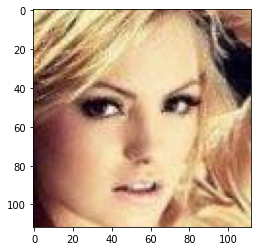

  5%|▌         | 1/20 [00:01<00:23,  1.25s/it]

tensor(0)


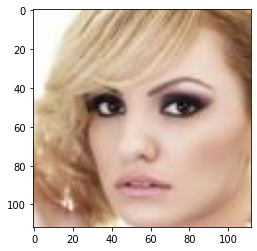

 10%|█         | 2/20 [00:01<00:14,  1.24it/s]

tensor(0)


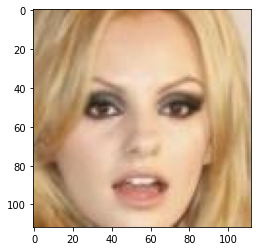

 15%|█▌        | 3/20 [00:01<00:09,  1.81it/s]

tensor(0)


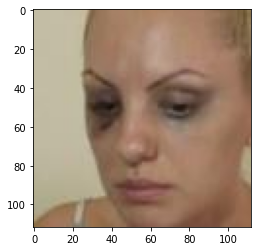

 20%|██        | 4/20 [00:02<00:06,  2.43it/s]

tensor(0)


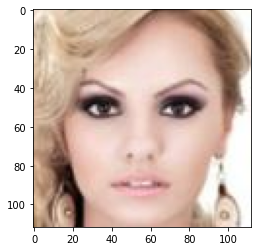

 25%|██▌       | 5/20 [00:02<00:05,  2.99it/s]

tensor(0)


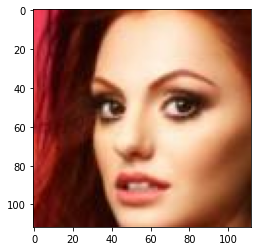

 30%|███       | 6/20 [00:02<00:03,  3.55it/s]

tensor(0)


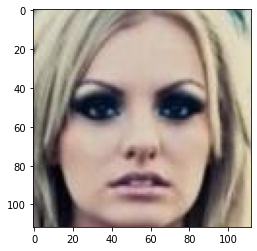

 35%|███▌      | 7/20 [00:02<00:03,  3.99it/s]

tensor(0)


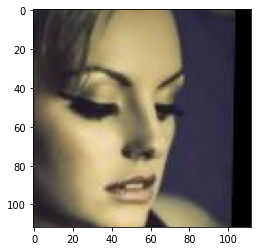

 40%|████      | 8/20 [00:03<00:03,  3.82it/s]

tensor(0)


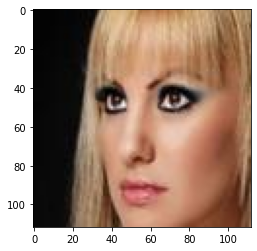

 45%|████▌     | 9/20 [00:03<00:02,  4.32it/s]

tensor(0)


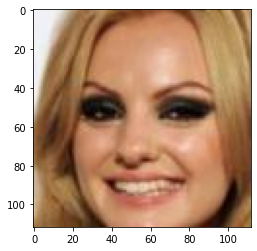

 50%|█████     | 10/20 [00:03<00:02,  4.30it/s]

tensor(0)


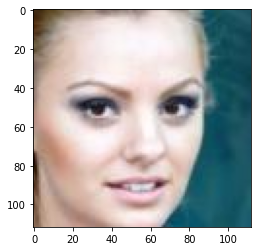

 55%|█████▌    | 11/20 [00:03<00:02,  3.17it/s]

tensor(0)


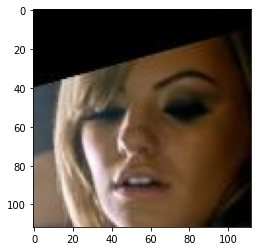

 60%|██████    | 12/20 [00:04<00:02,  3.76it/s]

tensor(0)


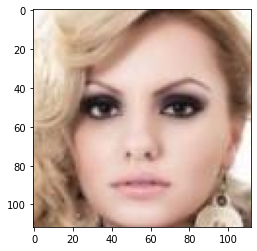

 65%|██████▌   | 13/20 [00:04<00:01,  4.13it/s]

tensor(0)


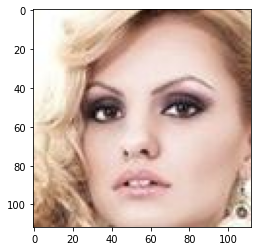

 70%|███████   | 14/20 [00:04<00:01,  4.18it/s]

tensor(0)


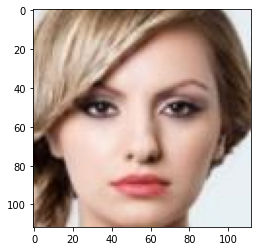

 75%|███████▌  | 15/20 [00:04<00:01,  4.77it/s]

tensor(0)


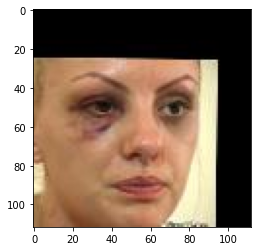

 80%|████████  | 16/20 [00:04<00:00,  4.96it/s]

tensor(0)


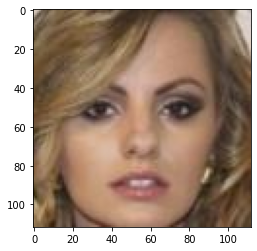

 85%|████████▌ | 17/20 [00:05<00:00,  4.62it/s]

tensor(0)


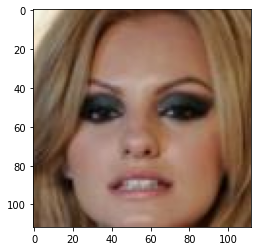

 90%|█████████ | 18/20 [00:05<00:00,  4.41it/s]

tensor(0)


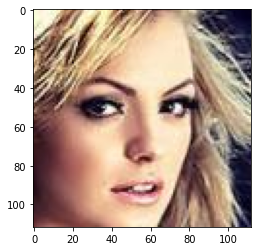

 95%|█████████▌| 19/20 [00:05<00:00,  4.12it/s]

tensor(0)


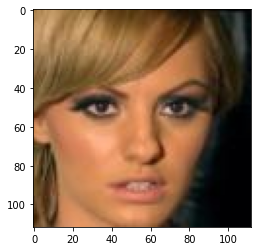

100%|██████████| 20/20 [00:05<00:00,  3.45it/s]

tensor(0)


In [5]:
import matplotlib.pyplot as plt 
imgidx = np.array(list(imgrec.keys))
for idx in tqdm(imgidx[:20]):
    try:
        s = imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        plt.imshow(sample)
        plt.show()
        print(label)
    except Exception as e:
        print(idx)
        raise e


In [ ]:
#extract infomation from old rec 
s = imgrec.read_idx(0)
header, _ = mx.recordio.unpack(s)
if header.flag > 0:
    header0 = (int(header.label[0]), int(header.label[1]))
    imgidx = np.array(range(1, int(header.label[0])))
else:
    imgidx = np.array(list(imgrec.keys))
print(len(imgidx))
#write header record
imgrec_new.write_idx(0,s)

#write the rest records, if which record is broken, ignore it
idx_new=1
failed_idx=[]
for idx in tqdm(imgidx):
    try:
        s = imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if np.isnan(sample).any():
            failed_idx.append(idx)
            raise(Exception("nan"))
        if sample.shape[0]<=0:
            failed_idx.append(idx)
            raise(Exception("nan"))
        if np.count_nonzero(sample) <= 5:
            failed_idx.append(idx)
            raise(Exception("nan"))
        # imgrec_new.write_idx(idx_new, s)
        idx_new+=1
    except Exception as e:
        failed_idx.append(idx)
        print(idx)
        raise e
        continue

imgrec.close()
imgrec_new.close()

### Read from files

In [ ]:
from glob import glob 

files = glob("/share/team/thucth/data/FaceReg/faces_emore/imgs/*")
print(len(files))
for file in files[:10]:
    try:
        img = cv2.imread(file)
        plt.imshow()
    except Exception as e:
        print(file)
        raise e
